# 4.3. Wstępna obróbka danych

Zbiór danych, na którym pracujemy, jest na szczęście kompletny i nie wymaga wstępnego uzupełniania

In [1]:
import pandas as pd

In [2]:
wine_quality_df = pd.concat([
    pd.read_csv("./data/wine-quality/winequality-white.csv", 
                delimiter=";")
        .assign(color="white"),
    pd.read_csv("./data/wine-quality/winequality-red.csv", 
                delimiter=";")
        .assign(color="red"),
])
wine_quality_df.sample(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
563,7.4,0.30,0.22,1.4,0.046,16.0,135.0,0.99280,3.08,0.77,10.4,7,white
4313,6.4,0.27,0.30,1.6,0.040,19.0,86.0,0.99089,3.32,0.65,11.5,6,white
197,11.5,0.30,0.60,2.0,0.067,12.0,27.0,0.99810,3.11,0.97,10.1,6,red
1071,7.5,0.77,0.20,8.1,0.098,30.0,92.0,0.99892,3.20,0.58,9.2,5,red
3396,7.4,0.29,0.28,10.2,0.032,43.0,138.0,0.99510,3.10,0.47,10.6,6,white


## Zamiana zmiennych kategorycznych

Wykorzystamy one-hot encoding do zapisu zmiennych zawierających kategorie, tak jak opisaliśmy w rozdziale [2.4](2_4_data_types_representation.ipynb). W naszym wypadku jest to tylko jedna zmienna, dokładnie ta oznaczająca kolor wina, którą sami wprowadziliśmy do zbioru.

In [4]:
wine_quality_df = pd.get_dummies(wine_quality_df)
wine_quality_df.sample(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
3566,7.6,0.38,0.28,4.2,0.029,7.0,112.0,0.99060,3.00,0.41,12.6,6,0,1
229,7.1,0.24,0.41,17.8,0.046,39.0,145.0,0.99980,3.32,0.39,8.7,5,0,1
488,7.4,0.29,0.29,1.6,0.045,53.0,180.0,0.99360,3.34,0.68,10.5,6,0,1
1105,5.5,0.32,0.45,4.9,0.028,25.0,191.0,0.99220,3.51,0.49,11.5,7,0,1
2477,6.1,0.27,0.31,1.5,0.035,17.0,83.0,0.99076,3.32,0.44,11.1,7,0,1


Nie posiadamy ponadto żadnych innych zmiennych niż numeryczne, więc dalsza zamiana formatu nie ma sensu.

## Wyliczanie dodatkowych cech dla modelu

Patrząc na nasz słownik atrybutów, można zauważyć że cecha "total sulfur dioxide" jest sumą pola "free sulfur dioxide" i dodatkowo nieobecnej w naszej ramce danych zawartości tzw. związanego (ang. *bound*) dwutlenku siarki. Możemy dodatkowo wyliczyć tę cechę, żeby sprawdzić czy nie jest ona istotna.

In [6]:
wine_quality_df["bound sulfur dioxide"] = \
    wine_quality_df["total sulfur dioxide"] - wine_quality_df["free sulfur dioxide"]
wine_quality_df.sample(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white,bound sulfur dioxide
434,10.4,0.41,0.55,3.20,0.076,22.0,54.0,0.99960,3.15,0.89,9.9,6,1,0,32.0
2329,7.6,0.30,0.40,2.20,0.054,29.0,175.0,0.99445,3.19,0.53,9.8,5,0,1,146.0
1529,6.6,0.21,0.49,18.15,0.042,41.0,158.0,0.99970,3.28,0.39,8.7,6,0,1,117.0
169,9.8,0.42,0.48,9.85,0.034,5.0,110.0,0.99580,2.87,0.29,10.0,5,0,1,105.0
3428,6.4,0.32,0.27,4.90,0.034,18.0,122.0,0.99160,3.36,0.71,12.5,6,0,1,104.0


In [7]:
wine_quality_df.corr() \
    .style.background_gradient(cmap="coolwarm")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white,bound sulfur dioxide
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740,-0.486740,-0.298976
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036,-0.653036,-0.377988
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397,0.187397,0.190929
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821,0.348821,0.459126
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678,-0.512678,-0.271742
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644,0.471644,0.506334
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357,0.700357,0.962636
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645,-0.390645,0.030261
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129,-0.329129,-0.239675
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218,-0.487218,-0.269459


Jak widać, nowo stworzona cecha jest ściśle skorelowana z łączną zawartością dwutlenku siarki, więc rozsądnym podejściem wydaje się być usunięcie jej ze zbioru danych. Skorzystamy jednak z tego potencjalnego problemu, żeby zobaczyć jak zachowuje się model, gdy dostanie dwie niemal równoważne cechy.

## Sformułowanie problemu

Do tej pory nie wspomnieliśmy jeszcze problemu jakim będziemy się zajmować. Naszym celem będzie stworzenie modelu, który będzie w stanie przewidzieć jaka jest jakość wina na podstawie jego cech fizykochemicznych. Zbiór danych, który rozważamy, zawiera ocenę jakości i chcielibyśmy być w stanie przewidzieć czy nowe wino jakie chcemy wypić będzie w porządku.

Kolejnym cennym krokiem jest sprawdzenie tego jak poszczególne zmienne różnią się ze względu na ocenę jakości. Pozwala to mieć lepszy pogląd na predyktory i ich potencjalną przydatność.

In [34]:
import matplotlib.pyplot as plt

C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\pandas\plotting\_matplotlib\tools.py:190: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
C:\Users\lukaw\anaconda3\envs\intro-to-ml\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F542D3748>,
      dtype=object)

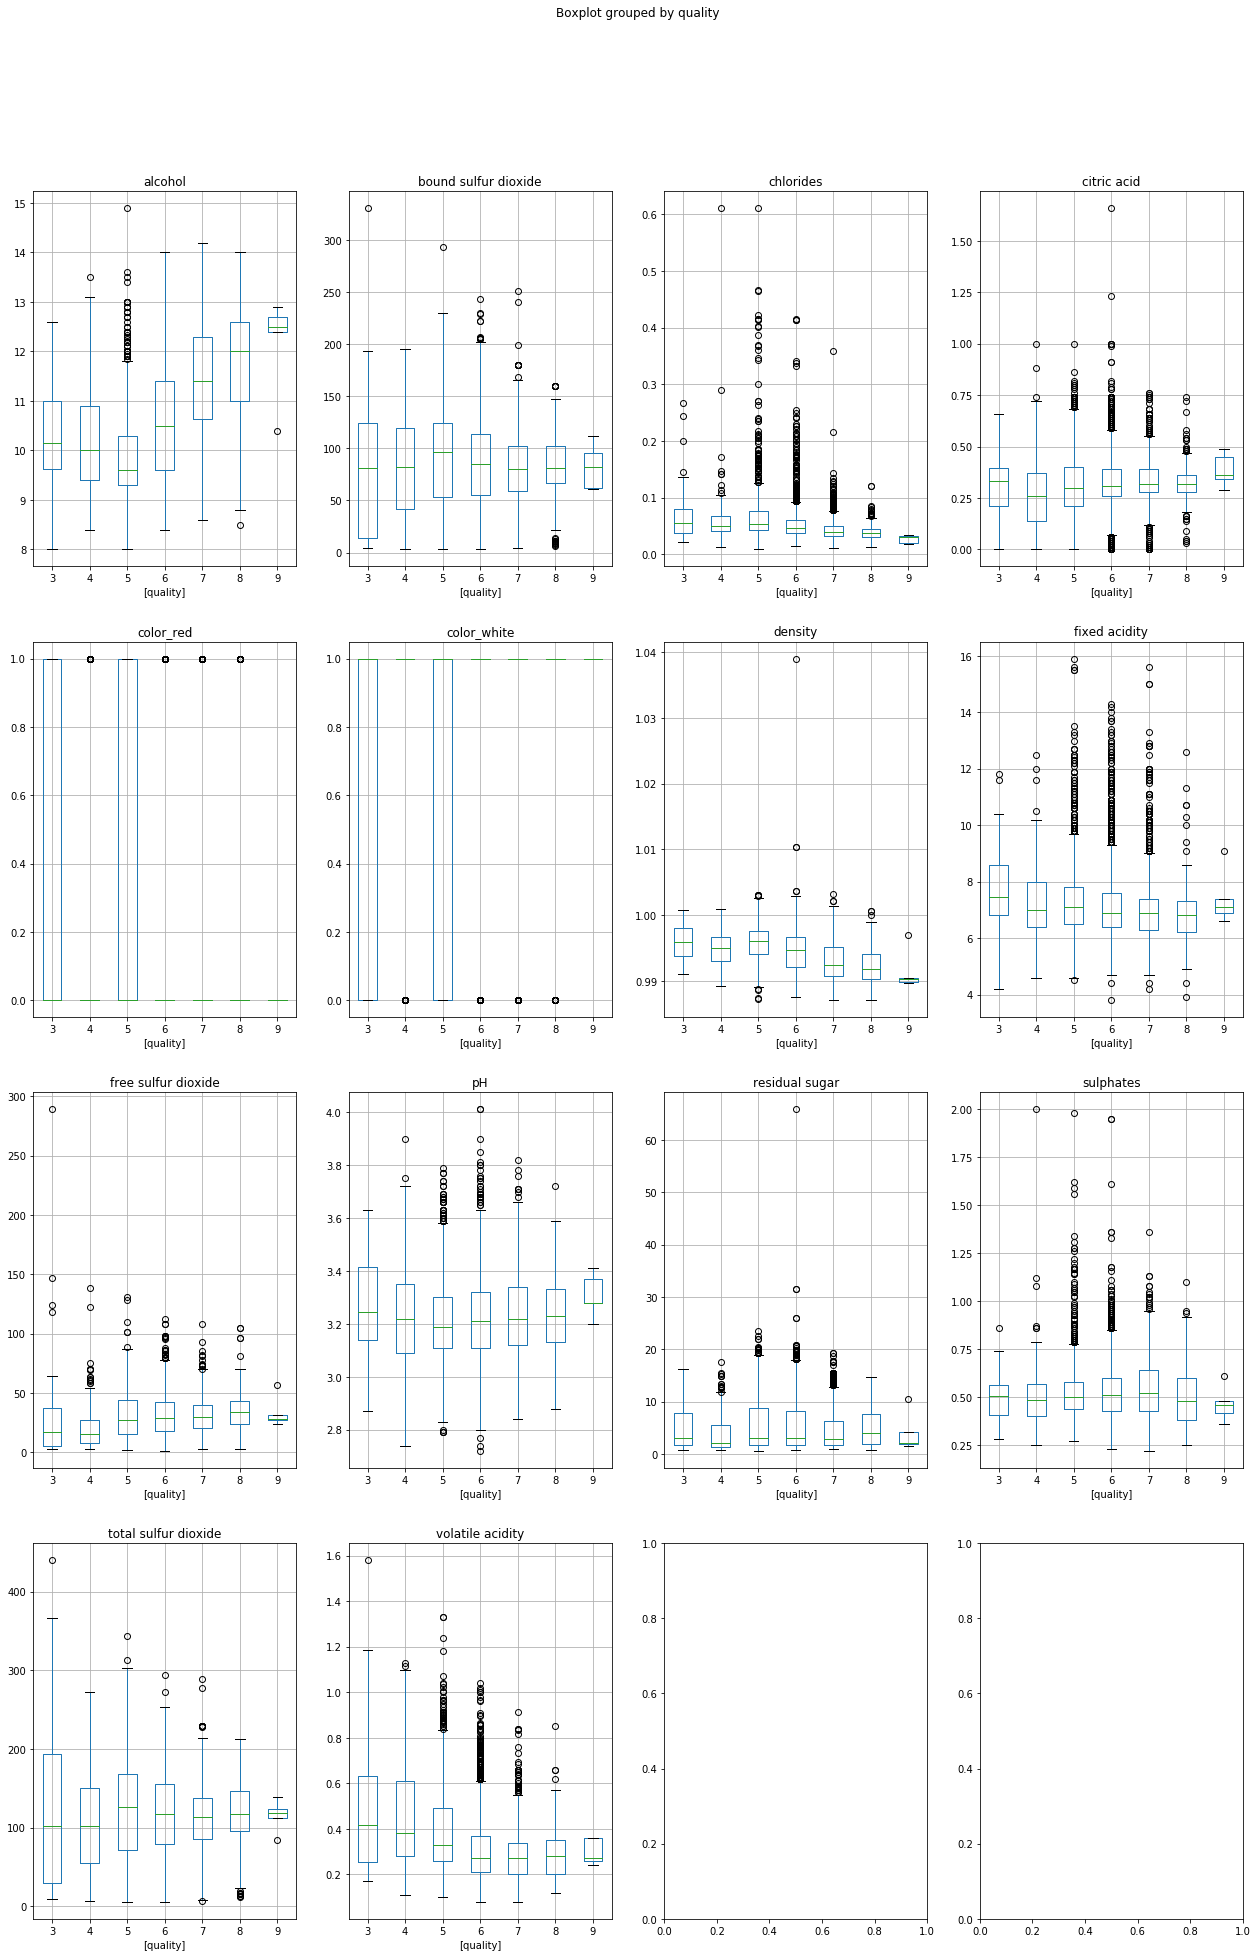

In [45]:
fig, ax = plt.subplots(4, 4, sharey=False, figsize=(21.0, 32.0))
wine_quality_df.boxplot(by="quality", ax=ax.flatten()[:-2],
                        layout=(4, 4))

In [46]:
wine_quality_df.to_parquet("./data/wine-quality.parquet")